# Cluster Analysis MASL 2023

**OBBIETTIVO**: Confrontare il clustering con $K = 4$, (come i gruppi descritti nel paper) e con un $K$ empirico, corrispondente al punto *elbow*.

**DATI**: Dataset composto da 65 osservazioni riguardanti la salute mentale, più precisamente ansia e depressione.


In [1]:
import pandas as pd
import numpy as np
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

seed = 2023

## Importare e standardizzare i dati.

L'importazione dei dati avviene tramite la libreria [pandas](https://pandas.pydata.org/docs/) che mette a disposizione un metodo per importare i file excel.

Questi dati sono solo numerici, fatta eccezione della variabile categorica del genere.

Per la standardizzazione rimuoviamo temporaneamente tale colonna, standardizziamo e la reinseriamo successivamente.

La standardizzazione viene effettuata tramite l'oggetto [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

La standardizzazione è implementata come segue: $$z_i = \frac{x_i - \bar{x}}{\sigma}$$

> Questo oggetto è utile durante le pipeline e per la memorizzazione delle medie e deviazioni standard.

In [2]:
anxiety = pd.read_excel("Data/anxiety.xlsx")
anxiety.drop(["Average weekday","Average weekend day",'ID No'],axis=1, inplace=True)
anxiety.dropna(inplace=True,axis=0)
anxiety.reset_index(inplace=True)
anxiety["Gender"] = anxiety["Gender"] - 1.0
gender = anxiety["Gender"]
anxiety.drop(["Gender"],axis=1,inplace=True)

scaler = StandardScaler()

scaler = StandardScaler()
anxiety = pd.DataFrame(scaler.fit_transform(anxiety), columns=anxiety.columns)
anxiety["isFemale"] = gender

print("===============Pezzo di Dataset Standardizzato================")
print(anxiety.head().T.iloc[1:5])

===============Pezzo di Dataset Standardizzato================
                     0         1         2         3         4
Age          -0.312287 -0.226639 -0.312287  0.030306 -0.911825
Height (m)   -0.843423 -0.841450 -0.841820 -0.843423 -0.843300
Weight (kgs) -1.270962  0.395851 -0.656873 -1.095508  0.659032
BMI          -0.401234  0.269065 -0.711751 -0.154943  2.183643


## K-Means con $K=4$

Iniziamo vedendo la separazione e coesione dei clusters con $K=4$.

Essendo il K-Means sensibile ai dati non globulari utilizziamo la PCA per avere le colonne incorrelate (e quindi dati globulari di conseguenza). Successivamente possiamo anche plottare le 2 componenti principali che spiegano maggiormente la varianza per avere una rappresentazione visiva dei clusters.

Nel modulo [scikitlearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) non possiamo gestire le variabili categoriche. 


### Componenti Principali per la visualizzazione

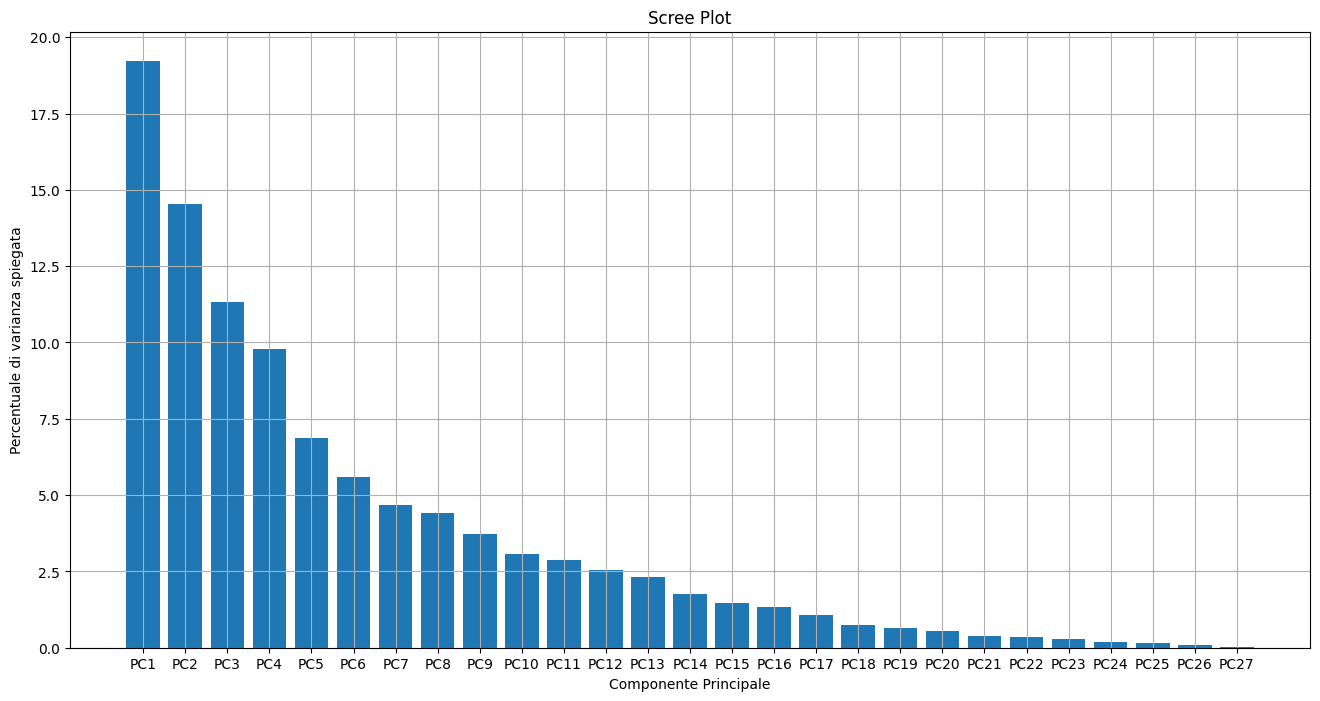

In [3]:
pca = PCA()
reduced_data = pca.fit_transform(anxiety)

variation = np.round(pca.explained_variance_ratio_*100,decimals=2)
labels = ["PC"+str(x) for x in range(1,len(variation) +1 )]

plt.figure(figsize=(16,8))
plt.bar(x=range(1,len(variation) +1 ), height=variation,tick_label=labels)
plt.ylabel("Percentuale di varianza spiegata")
plt.xlabel("Componente Principale")
plt.title("Scree Plot")
plt.grid()
plt.show()


Le due componenti principale spiegano meno del 30% della varianza. A noi serve solo a fini di visualizzazione, in seguito useremo tutte le componenti principali.

In [4]:
kmeans = KMeans(init="k-means++", n_clusters=4, n_init=10, random_state=seed)
kmeans.fit(reduced_data[:,0:2])

KMeans(n_clusters=4, n_init=10, random_state=2023)

> Il seguente codice è stato preso dal tutorial per la visualizzazione del K-Means tramite PCA della stessa libreria [scikitlearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py).

In [5]:
def plot_KMeans(kmeans, reduced_data):
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].
    
    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(16,9))
    plt.clf()
    plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect="auto",
        origin="lower",
    )
    
    plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=169,
        linewidths=3,
        color="w",
        zorder=10,
    )
    plt.title(
        "K-means clustering on the digits dataset (PCA-reduced data)\n"
        "Centroids are marked with white cross"
    )
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(f"PC1 {variation[0]}% della varianza")
    plt.ylabel(f"PC2 {variation[1]}% della varianza")
    plt.show()

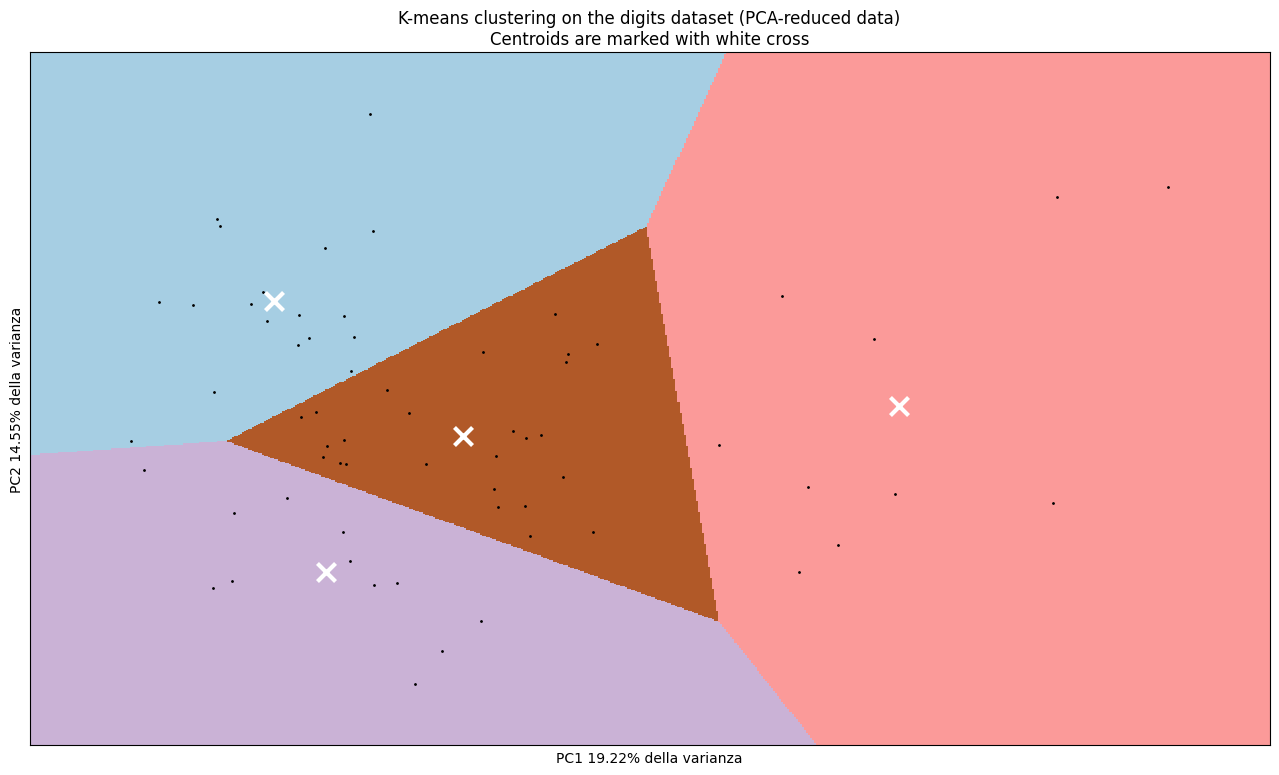

In [6]:
plot_KMeans(kmeans,reduced_data)

In [7]:
kmeans = KMeans(init="k-means++", n_clusters=4, n_init=10, random_state=seed)
kmeans.fit(reduced_data)

KMeans(n_clusters=4, n_init=10, random_state=2023)

## Punto di gomito

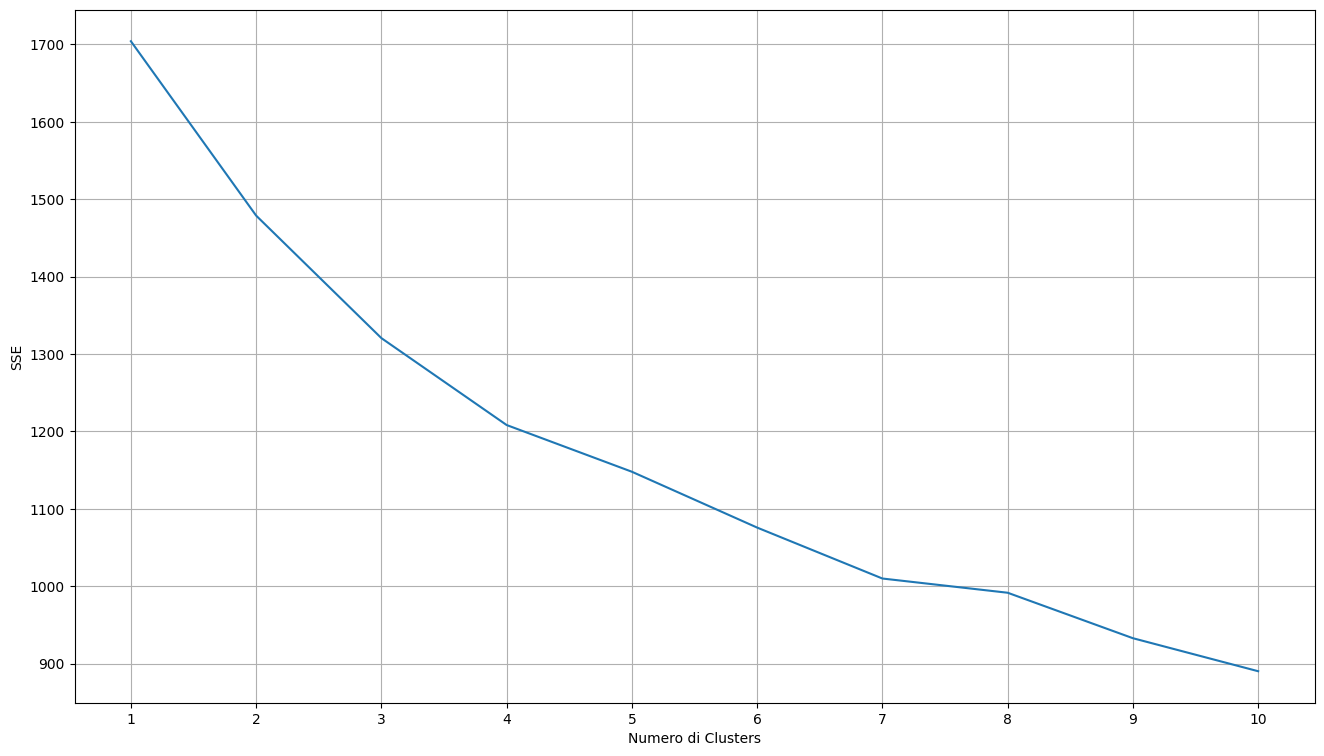

In [8]:
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": seed,
}
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(reduced_data)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(16,9))
plt.plot(range(1,11),sse)
plt.xticks(range(1, 11))
plt.xlabel("Numero di Clusters")
plt.ylabel("SSE")
plt.grid()
plt.show()

In [9]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

elbow = kl.elbow
print(f"Il punto di gomito è: {elbow}")

Il punto di gomito è: 4


L'analisi ci porta ad avere come punto di gomito 4, ovvero quanto affermato dalla teoria.

Questo però utilizzando SSE.

Proviamo adesso ad utilizzare come metrica [Silhouette](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

Questa metrica è un numero compreso tra $[-1,1]$, più alto è meglio. 0 indica clusters che si sovrappongono. Tiene in considerazione sia la coesione del cluster che la separazione.

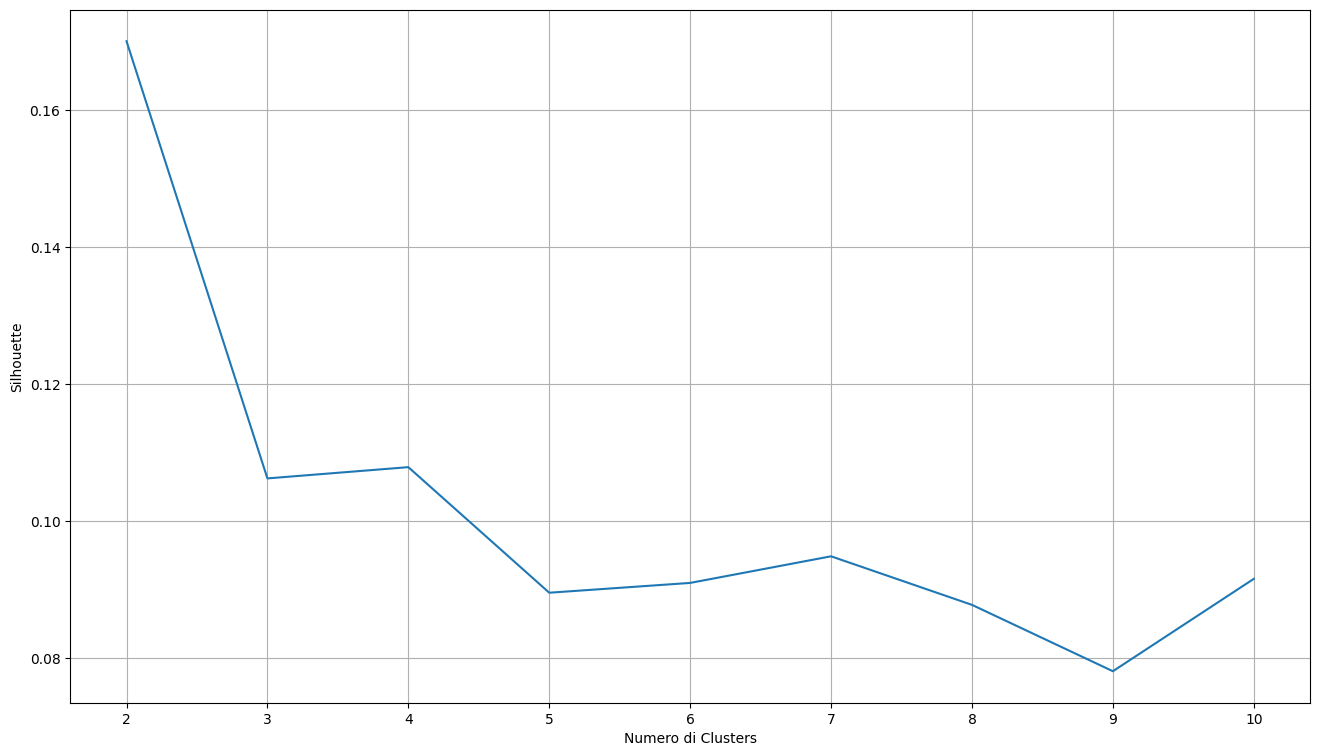

Il punto di gomito è: 3


In [10]:
silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(reduced_data)
    score = silhouette_score(reduced_data, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.figure(figsize=(16,9))
plt.plot(range(2,11),silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Numero di Clusters")
plt.ylabel("Silhouette")
plt.grid()
plt.show()

kl = KneeLocator(range(2, 11), silhouette_coefficients, curve="convex", direction="decreasing")

elbow = kl.elbow
print(f"Il punto di gomito è: {elbow}")


Secondo la metrica silhouette il punto di gomito è 3. Andiamo a visualizzare questo clustering.

> Sia 3 che 4 hanno punteggio molto simile e in generale i clusters non sono ben separati e omogenei.

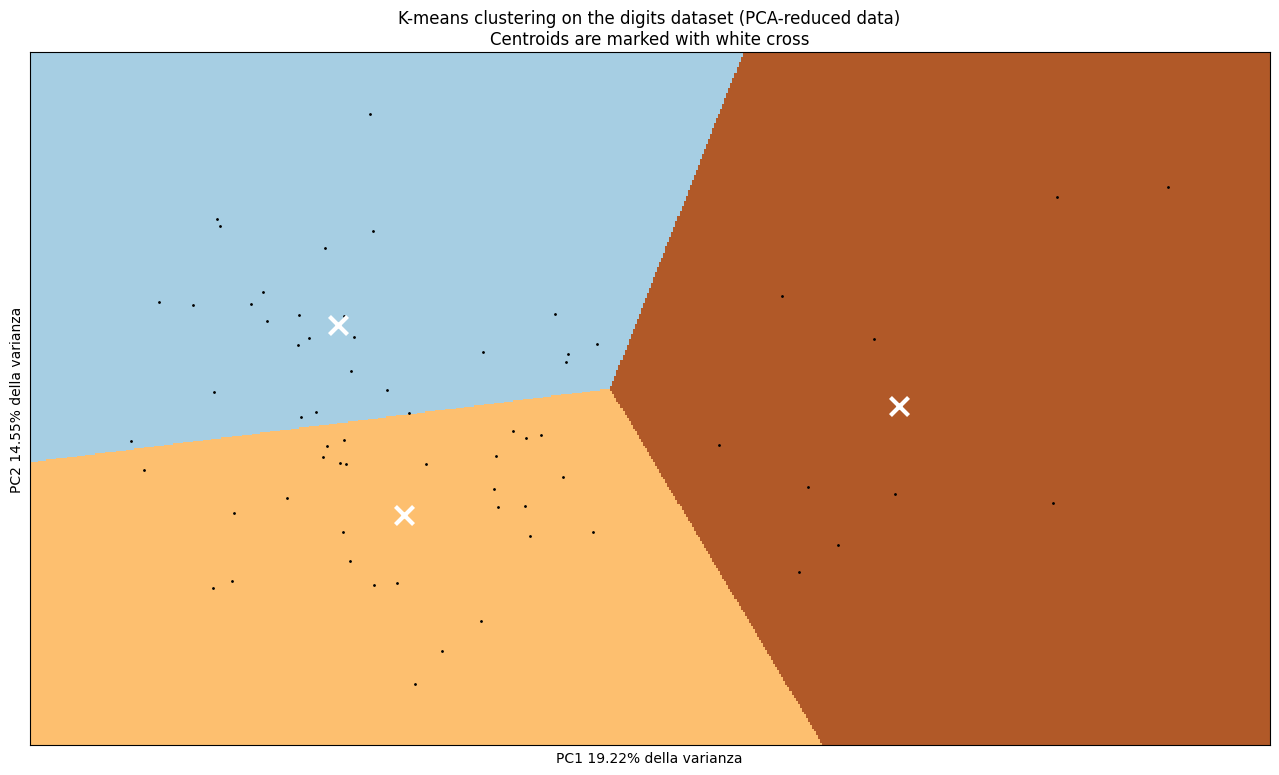

In [11]:
kmeans = KMeans(init="k-means++", n_clusters=3, n_init=10, random_state=seed)
kmeans.fit(reduced_data[:,0:2])
plot_KMeans(kmeans,reduced_data)

In conclusione, la scelta del numero di clusters deve essere dettata sia dalle metriche che da ciò che sappiamo del campo in analisi. Nel nostro caso la teoria ci dice che a seconda di un test possiamo classificare i pazienti in 4 gruppi di severità di sintomi.

Avendo ottenuto come punto di gomito tramite SSE 4 clusters (come nella teoria), possiamo utilizzare tale numero per ulteriori analisi.